In [10]:
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
 
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import datasets


#### 선형회귀

In [ ]:
#선형처럼 보이는 데이터 생성
x = 2 * np.random.rand(100,1)
y = 4 + 3 * x + np.random.rand(100,1)

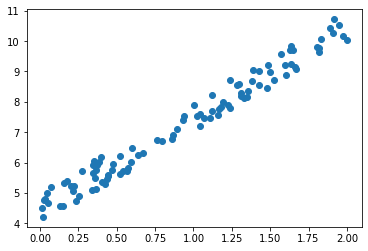

In [ ]:
plt.scatter(x, y)
plt.show()

In [ ]:
#dot()메서드를 사용하여 행렬곱
x_b = np.c_[np.ones((100,1)), x]
theta_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [ ]:
theta_best

array([[4.48165368],
       [2.96576223]])

In [ ]:
#가우시안 잡음
x_new = np.array([[0],[2]])
x_new_b = np.c_[np.ones((2,1)), x_new]
y_predict = x_new_b.dot(theta_best)
y_predict

array([[ 4.48165368],
       [10.41317813]])

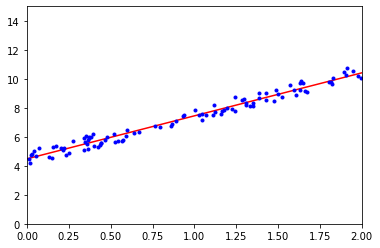

In [ ]:
#모델 예측 그래프
plt.plot(x_new, y_predict, 'r-')
plt.plot(x,y, 'b.')
plt.axis([0,2,0,15])
plt.show()

In [ ]:
#sklearn에서 선형회귀
lin_reg = LinearRegression()
lin_reg.fit(x,y)

LinearRegression()

In [ ]:
lin_reg.intercept_, lin_reg.coef_

(array([4.48165368]), array([[2.96576223]]))

In [ ]:
lin_reg.predict(x_new)

array([[ 4.48165368],
       [10.41317813]])

In [ ]:
#LinearRegression 클래스는 scipy.linalg.lstsq()함수를 기반으로 함
# 함수 직접 호출 가능
theta_best_svd, residuals, rank, s = np.linalg.lstsq(x_b, y, rcond = 1e-6)
theta_best_svd

array([[4.48165368],
       [2.96576223]])

In [ ]:
#유사역행렬을 직접 구할 수 있다
np.linalg.pinv(x_b).dot(y)

array([[4.48165368],
       [2.96576223]])

#### 계산복잡도

In [ ]:
#경사하강법 간단한 알고리즘
eta = 0.1 #학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta)-y)
    theta = theta - eta * gradients
theta

array([[4.48165368],
       [2.96576223]])

In [ ]:
#간단한 확률적 경사하강법 구현
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta)- yi)
        eta = learning_schedule(epoch * m + 1)
        theta = theta - eta * gradients
theta

array([[4.47980523],
       [2.97699877]])

In [ ]:
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0= 0.1)
sgd_reg.fit(x, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.46616003]), array([2.97948061]))

미니배치 경사 하강법
- 미니배치라는 임의의 작은 샘플세트에 대해 그레이디언트를 계산
- 행렬 연산에 최적화된 하드웨어 GPU를 사용해서 얻는 성능 향상
- SGD보다 덜 불규칙하게 움직이고 최솟값에 더 가까이 도달하지만 최솟값에 빠져나오기 더 힘들지도

선형회귀 알고리즘 비교 (m은 훈련 샘플 수, n은 특성수)

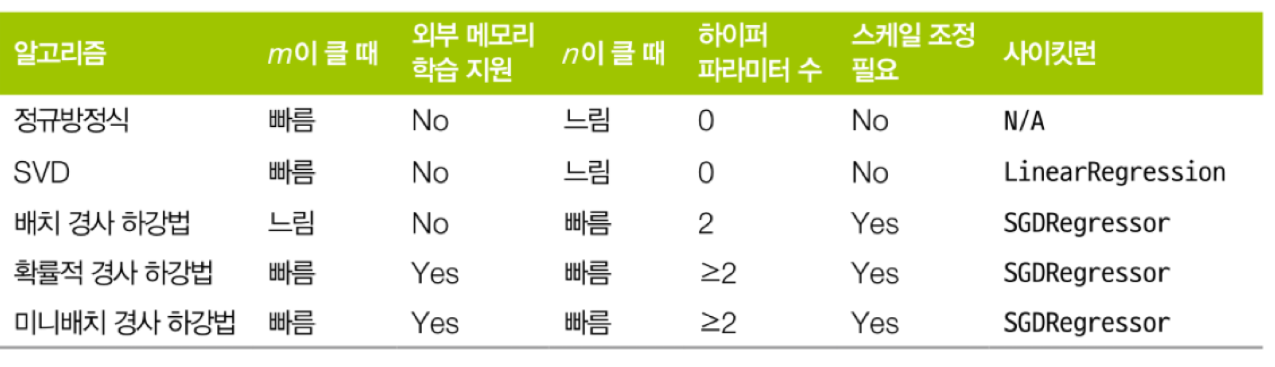

다항회귀 (PolynomialFeatures)
- 각 특성의 거즙제곱을 새로운 특성으로 추가 확장된 특성을 포함한 데이터셋에 선형모델을 훈련시키는 기법

In [ ]:
m = 100
x = 6 * np.random.rand(m, 1)-3
y = 0.5 * x**2 + np.random.randn(m,1)

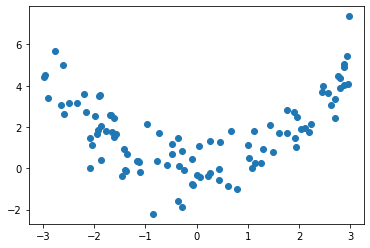

In [ ]:
plt.scatter(x,y)
plt.show()

In [ ]:
# 직선으로 표현하기 힘들기 떄문에 PolynomialFeatures를 사용하여 훈련데이터 변환
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
x_poly = poly_features.fit_transform(x)
x[0]

array([-1.87694793])

In [ ]:
x_poly[0]

array([-1.87694793,  3.52293355])

In [ ]:
#x_poly는 이제 원래 특성 x와 이특성의 제곱을 포함
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([-0.0535346]), array([[0.02669371, 0.54828994]]))

#### 학습곡선

In [ ]:
def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label = "train_set")
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label = "test_set")
    

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

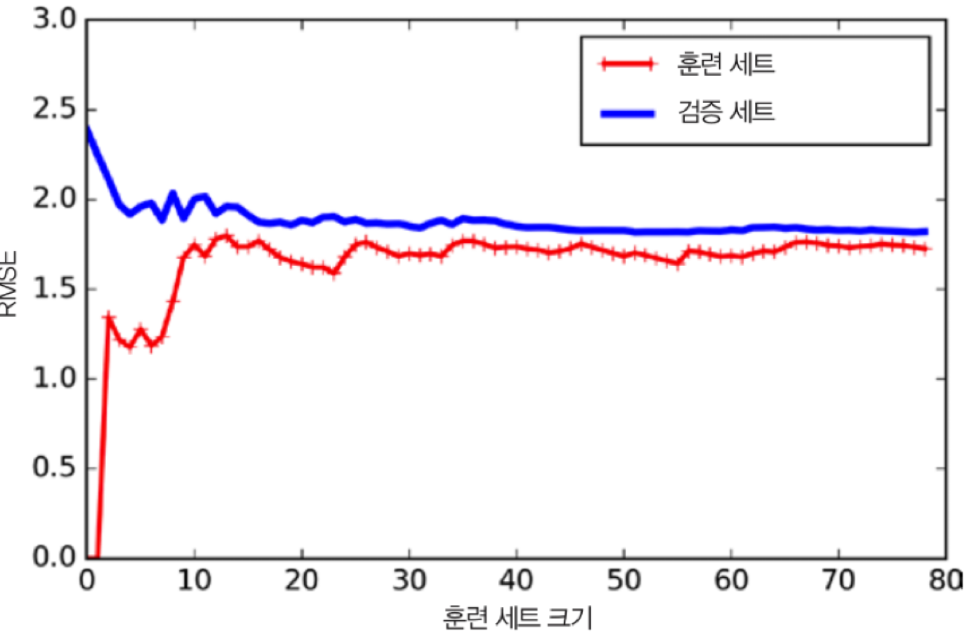

In [ ]:
#10차 다항 회귀 모델의 학습 곡선
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree =10, include_bias = False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, x, y)

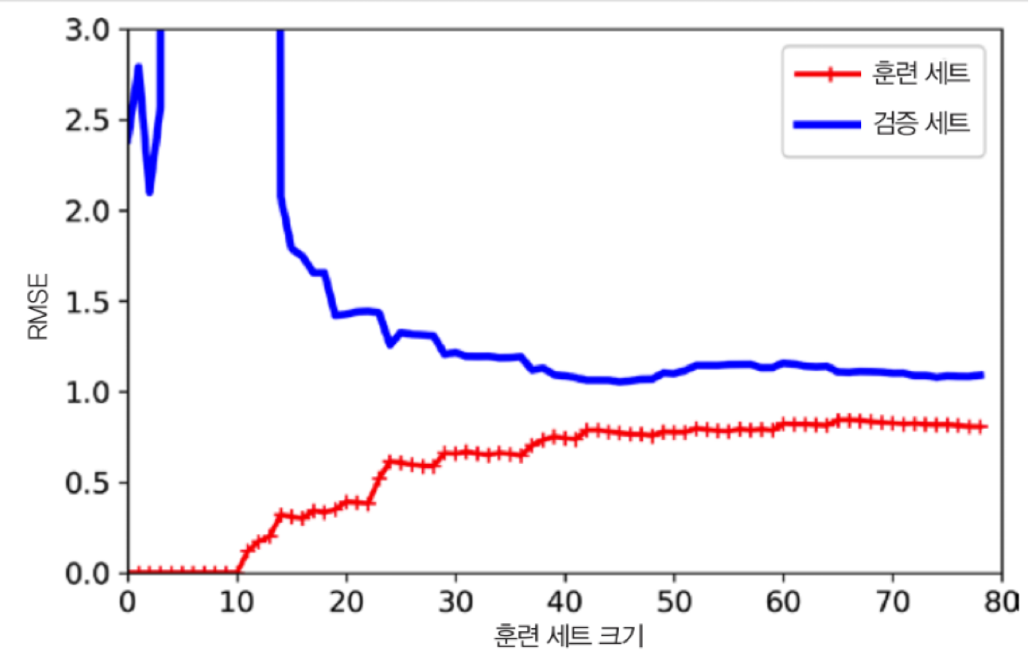

두 학습곡선의 차이점
- 훈련 데이터의 오차가 선형회귀 모델보다 훨씬 낮습니다.
- 두 곡선사이에 공간이 있습니다. 훈련데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고 과적합 모델의 특징,    
더 큰 훈련세트를 사용하면 두 곡선이 점점 가까워 진다
- 과적합모델 개선하는 한가지 방법중 하나 큰 더 많은 훈련 데이터를 추가하는법

편향/분산 트레이드오프
통계학과 머신러닝에 나온 중요한 이론 하나는 모델의 이란화 오차는 세가지 다른 종류의 오차의 합으로 표현할 수 있다는 사실
 - 편향
 일반화 오차중에서 평향은 잘못된 가정으로 인한것 데이터가 실제로는 2차인데 선형으로 가정하는 경우 , 편향이 큰 모델은 훈련 데이터에 과소적합 되기 쉬움
 - 분산 
 분산은 훈련데이터에 있는 작은 변동에 모델이 과도하게 민감하기 떄문에 나타남
 자유도가 높은 모델이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향
 - 줄일 수 없는 오차
 줄일 수 없는 오차는 데이터 자체에 있는 잡음 떄문에 발생 이오차를 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것    
      
          
 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향을 줄어듬 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아짐 그래서 트레이드오프라고 부름

#### 릿지 회귀
- 규제가 추가된 선형 회귀 버전
- 데이터를 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 노력
- 입력 특성의 스케일에 민감하기 떄문에 스케일을 맞추는것이 중요(예를 들면 StandardScaler를 사용)
- 릿지 회귀는 정규방적식, 경사하강법 사용 가능


In [ ]:
#정규방정식 릿지회귀
ridge_reg = Ridge(alpha=1, solver = 'cholesky')
ridge_reg.fit(x,y)
ridge_reg.predict([[1.5]])

array([[1.99135613]])

In [ ]:
#확률적 경사하강법
sgd_reg = SGDRegressor(penalty = 'l2') #비용 함수에 가중치 백터 노름의 제곱으로 나눈 규제항을 추가
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

array([1.95492062])

#### 라쏘 회귀
- 선형 회귀의 또다른 규제버전, 릿지 회귀처럼 비용함수에 규제항을 더하지만 노름의 제곱을 2로나누것 대신 가중치 벡터의 노름을 사용
- 덜 중요한 특성의 가중치를 제거하려고 함
- 자동으로 특성을 선택하고 희소모델을 만듬
- 라쏘의 비용 함수는 미분이 가능하지 않지만 서브그레이디언트 벡터를 사용하면 경사하강법 적용하는데 문제없음

In [ ]:
#Lasso 클래스를 사용한 간단한 사이킷런 예제
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(x,y)
lasso_reg.predict([[1.5]])

array([1.94579026])

#### 엘라스틱넷
 - 릿지 회귀와 라쏘 회귀의 절충모델
 - 규제항은 릿지와 회귀의 규제항을 단신히 더해서 사용하며 혼합비율을 사용해 조정
 - 비율이 0이면 릿지 회귀, 1이면 라쏘 회귀

- 3가지중 릿지가 기본, 쓰이는 특성이 몇개 뿐이라고 의심되면 그때 라쏘나 엘라스틱넷이 낫다
- 특성 수가 훈련 샘플 수 보다 많거나 특성 몇개가 강하게 연관되어 있을 때는 보통 라쏘보단 엘라스틱넷

In [ ]:
#간한한 예제
elastic_net = ElasticNet(alpha = 0.1, l1_ratio=0.5)
elastic_net.fit(x,y)
elastic_net.predict([[1.5]])

array([1.96527264])

#### 조기종료
- 에러 최소값에 도달하면 훈련 중지시키는 것
- 모델이 과대적합되기 시작할때 검증에러가 최소에 도달하는 즉시 훈련을 멈춤
- 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 그리 매끄럽지 않아 최소값에 도달했는지 확인 어려움 해결책은 검증에러가 일정시간 동안 최솟값보다 클 때 (모델이 나아지지 않는다고 확신이 들때) 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌림

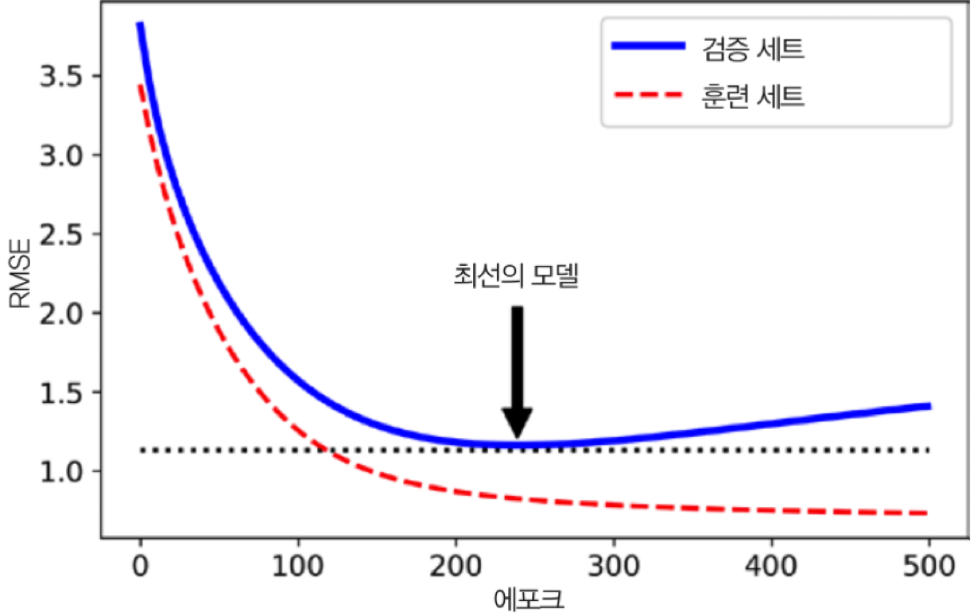

In [ ]:
# 기본적인 구현 코드
# 데이터준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)), #기본다항식 형태를 만듬
    ("std_scaler", StandardScaler())
])
x_train_poly_scaled = poly_scaler.fit_transform(x_train) #데이터를 다항식 형태로 바꿈
x_val_poly_scaled = poly_scaler.transform(x_val)

sgd_reg = SGDRegressor(max_iter = 1, tol =-np.infty, warm_start= True, #처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련이어감
                       penalty = None, learning_rate = "constant", eta0 = 0.0005)

minimum_val_error = float('inf') #Inf = 양의 무한대 
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train) #훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)


#### 로지스틱 회귀
- 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용됨
- 추정확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 혹한다고 예측
- 50%가 넘지 않으면 속하지 않는다고 예측 (이진분류기)
- 입력 특성의 가중치 합을 계산, 결과값을 로지스틱을 출력(시그모이드함수)


#### 결정경계

In [3]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [16]:
X = iris['data'][:,3:] #꽃잎의 너비
y = (iris['target'] == 2).astype(int) # iris-virginica 1, 아니면 0

In [17]:
#로지스틱 회귀모델 훈련
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

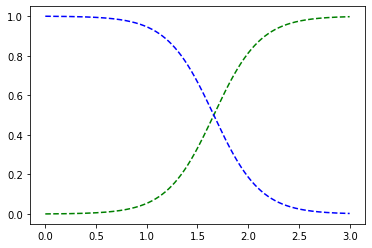

In [18]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g--", label = 'Iris virginiva')
plt.plot(X_new, y_proba[:,0], "b--", label = "Not Iris virginica")

In [19]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

#### 소프트맥스 회귀
- 여러개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화 이를 소프르맥스회귀, 또는 다항로지스틱 회귀라고 함
- 샘플 X가 주어지면 각 클래스 K에 대핸 점수 (x)를 계산하고 그 점수에 소프트맥스함수를 적용하여 각 클래스의 학률을 추정
- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는것이 목표
- 크로스엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 목적에 부합
- 크로스앤트로피는 추정된 클래스의 확률이 타겟 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용

#### 크로스 엔트로피 
- 엔트로피와 유사 개념 앤트로피가 정답 나올 확률만을 대상으로 측정한 값이라면 크로스 엔트로피는 모델에서 예측한 확률과 정답확률을 모두 사용해 측정한 값
- 모델에서 예측한 확률값이 실제값과 비교했을 때 틀릴 수 있는 정보량
- 값이 적을 수록 모델이 데이터를 잘 예측
- 딥러닝의 손실함수로 많이 사용되며 딥러닝 예측값과 정답값의 크로스엔트로피 값을 줄이기 위해 가중치와 편향을 업데이트하며 학습 수행

In [21]:
# 소프트맥스 회귀를 사용하여 3개의 클래스로 분류
X = iris['data'][:,(2,3)]
y = iris["target"]
# multi_class = "multinomial" 소프트맥스 사용 가능
smax_reg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs",  C = 10)
smax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [22]:
#꽃잎 길이가 5, 너비가 2인 붓꽃의 품종 질의
#클래스 2라고 확인
smax_reg.predict([[5,2]])

array([2])

In [23]:
smax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])